<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stock_clustering_on_price_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/**

In [106]:
!pip install yfinance


In [107]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [108]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
ticker['Symbol']=ticker['Symbol'].apply(lambda x:str(x)+'.ns')

In [109]:
companies_dict=dict(ticker[['Company Name','Symbol']].values)

In [110]:
companies = sorted(companies_dict.items(), key=lambda x: x[1])

In [111]:
# Define which online source to use
#data_source = 'yahoo'

# define start and end dates
start_date = '2017-01-01'

# Use pandas_datareader.data.DataReader to load the desired data list(companies_dict.values()) used for python 3 compatibility
panel_data = yf.download(list(companies_dict.values()),start_date)

print(panel_data.axes)


[*********************100%***********************]  50 of 50 completed
[DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', name='Date', length=1210, freq=None), MultiIndex([('Adj Close', 'ADANIPORTS.NS'),
            ('Adj Close', 'ASIANPAINT.NS'),
            ('Adj Close',   'AXISBANK.NS'),
            ('Adj Close', 'BAJAJ-AUTO.NS'),
            ('Adj Close', 'BAJAJFINSV.NS'),
            ('Adj Close', 'BAJFINANCE.NS'),
            ('Adj Close', 'BHARTIARTL.NS'),
            ('Adj Close',       'BPCL.NS'),
            ('Adj Close',  'BRITANNIA.NS'),
            ('Adj Close',      'CIPLA.NS'),
            ...
      

In [112]:
# Find Stock Open and Close Values
stock_close = panel_data['Close']
stock_open = panel_data['Open']

print(stock_close.iloc[0])


ADANIPORTS.NS      273.799988
ASIANPAINT.NS      904.650024
AXISBANK.NS        447.750000
BAJAJ-AUTO.NS     2598.500000
BAJAJFINSV.NS     2949.649902
BAJFINANCE.NS      870.049988
BHARTIARTL.NS      285.553467
BPCL.NS            427.000000
BRITANNIA.NS      1443.224976
CIPLA.NS           566.000000
COALINDIA.NS       300.049988
DIVISLAB.NS        797.849976
DRREDDY.NS        3083.399902
EICHERMOT.NS      2252.395020
GRASIM.NS          676.443481
HCLTECH.NS         414.250000
HDFC.NS           1217.099976
HDFCBANK.NS        598.549988
HDFCLIFE.NS               NaN
HEROMOTOCO.NS     3030.550049
HINDALCO.NS        158.850006
HINDUNILVR.NS      825.349976
ICICIBANK.NS       229.045456
INDUSINDBK.NS     1087.449951
INFY.NS            500.549988
IOC.NS             163.725006
ITC.NS             240.949997
JSWSTEEL.NS        163.429993
KOTAKBANK.NS       714.799988
LT.NS              906.400024
M&M.NS             614.900024
MARUTI.NS         5466.000000
NESTLEIND.NS      5974.399902
NTPC.NS   

In [113]:
# Calculate daily stock movement
stock_close = np.array(stock_close).T
stock_open = np.array(stock_open).T

row, col = stock_close.shape

# create movements dataset filled with 0's
movements = np.zeros([row, col])

for i in range(0, row):
 movements[i,:] = np.subtract(stock_close[i,:], stock_open[i,:])

In [114]:
for i in range(0, len(companies)):
 print('Company: {}, Change: {}'.format(companies[i][0], sum(movements[i][:])))


Company: Adani Ports and Special Economic Zone Ltd., Change: -624.6506195068359
Company: Asian Paints Ltd., Change: -1003.80126953125
Company: Axis Bank Ltd., Change: -731.8001708984375
Company: Bajaj Auto Ltd., Change: -4200.2947998046875
Company: Bajaj Finserv Ltd., Change: -2449.864013671875
Company: Bajaj Finance Ltd., Change: -1251.1539916992188
Company: Bharti Airtel Ltd., Change: -568.0668640136719
Company: Bharat Petroleum Corporation Ltd., Change: -891.0501098632812
Company: Britannia Industries Ltd., Change: -4532.3427734375
Company: Cipla Ltd., Change: -1418.0498962402344
Company: Coal India Ltd., Change: -447.6504821777344
Company: Divi's Laboratories Ltd., Change: -986.6996459960938
Company: Dr. Reddy's Laboratories Ltd., Change: -6115.0948486328125
Company: Eicher Motors Ltd., Change: -4562.0811767578125
Company: Grasim Industries Ltd., Change: -448.9352111816406
Company: HCL Technologies Ltd., Change: -584.6251525878906
Company: Housing Development Finance Corporation Lt

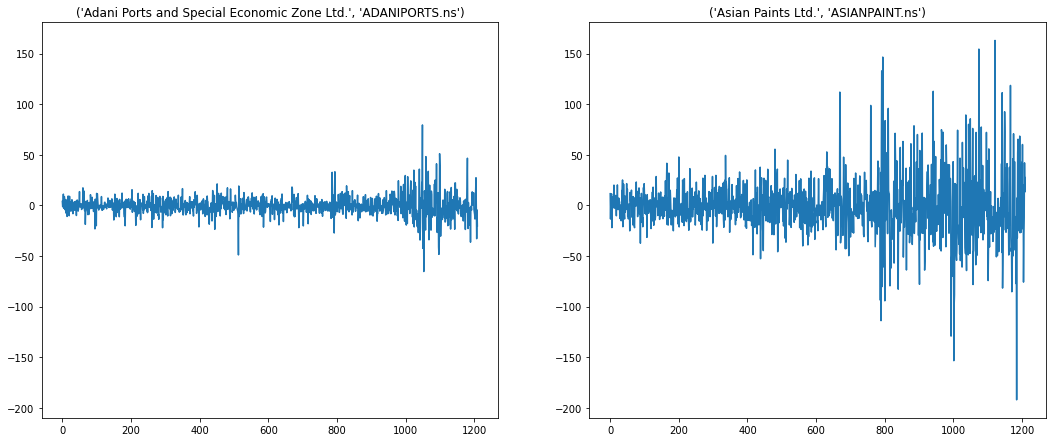

In [115]:
plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(movements[0][:])
plt.title(companies[0])

plt.subplot(222, sharey=ax1)
plt.plot(movements[1][:])
plt.title(companies[1])
plt.show()

In [116]:
np.isnan(movements).any()

True

In [117]:
movements[np.isnan(movements)] = np.median(movements[~np.isnan(movements)])

In [118]:
# import Normalizer
from sklearn.preprocessing import Normalizer
# create the Normalizer
normalizer = Normalizer()

new = normalizer.fit_transform(movements)

print(new.max())
print(new.min())
print(new.mean())

0.24409989088297596
-0.2901808372419687
-0.0016492201054437478


In [119]:
# import machine learning libraries
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# define normalizer
normalizer = Normalizer()

# create a K-means model with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter=1000)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

In [120]:
# fit pipeline to daily stock movements
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(max_iter=1000, n_clusters=10))])

In [121]:
# predict cluster labels
labels = pipeline.predict(movements)

# create a DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# display df sorted by cluster labels
print(df.sort_values('labels'))

    labels                                          companies
36       0            (Reliance Industries Ltd., RELIANCE.ns)
28       0           (Kotak Mahindra Bank Ltd., KOTAKBANK.ns)
23       0                (IndusInd Bank Ltd., INDUSINDBK.ns)
22       0                    (ICICI Bank Ltd., ICICIBANK.ns)
18       0    (HDFC Life Insurance Company Ltd., HDFCLIFE.ns)
17       0                      (HDFC Bank Ltd., HDFCBANK.ns)
16       0  (Housing Development Finance Corporation Ltd.,...
46       1                     (Titan Company Ltd., TITAN.ns)
3        1                   (Bajaj Auto Ltd., BAJAJ-AUTO.ns)
31       1              (Maruti Suzuki India Ltd., MARUTI.ns)
30       1                 (Mahindra & Mahindra Ltd., M&M.ns)
19       1                (Hero MotoCorp Ltd., HEROMOTOCO.ns)
13       1                 (Eicher Motors Ltd., EICHERMOT.ns)
24       2                            (Infosys Ltd., INFY.ns)
45       2                     (Tech Mahindra Ltd., TECHM.ns)
44      

In [122]:
# PCA
from sklearn.decomposition import PCA 

# visualize the results
reduced_data = PCA(n_components = 2).fit_transform(new)

# run kmeans on reduced data
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
labels = kmeans.predict(reduced_data)

# create DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster labels
print(df.sort_values('labels'))

    labels                                          companies
21       0           (Hindustan Unilever Ltd., HINDUNILVR.ns)
1        0                 (Asian Paints Ltd., ASIANPAINT.ns)
32       0                  (Nestle India Ltd., NESTLEIND.ns)
8        0          (Britannia Industries Ltd., BRITANNIA.ns)
48       1                                 (UPL Ltd., UPL.ns)
26       1                                 (ITC Ltd., ITC.ns)
14       1                (Grasim Industries Ltd., GRASIM.ns)
0        1  (Adani Ports and Special Economic Zone Ltd., A...
7        1       (Bharat Petroleum Corporation Ltd., BPCL.ns)
22       2                    (ICICI Bank Ltd., ICICIBANK.ns)
5        2                (Bajaj Finance Ltd., BAJFINANCE.ns)
4        2                (Bajaj Finserv Ltd., BAJAJFINSV.ns)
2        2                      (Axis Bank Ltd., AXISBANK.ns)
23       2                (IndusInd Bank Ltd., INDUSINDBK.ns)
9        3                             (Cipla Ltd., CIPLA.ns)
11      

<Figure size 432x288 with 0 Axes>

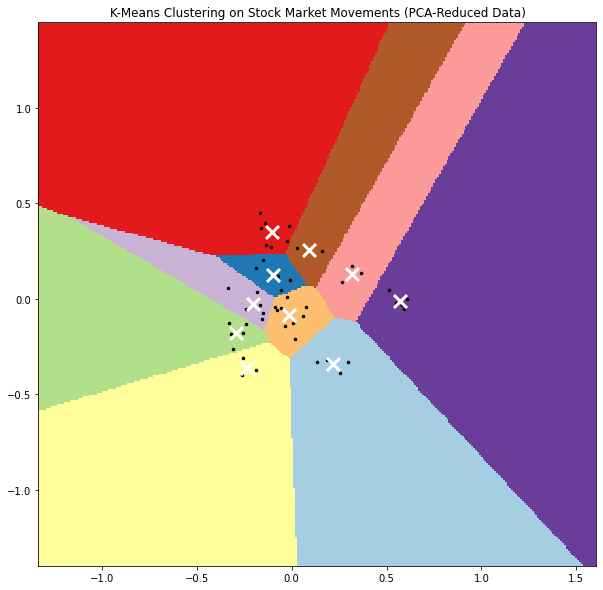

In [123]:
# Define step size of mesh
h = 0.01

# plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain abels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# define colorplot
cmap = plt.cm.Paired

# plot figure
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z, interpolation='nearest',
 extent = (xx.min(), xx.max(), yy.min(), yy.max()),
 cmap = cmap,
 aspect = 'auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)


# plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
 marker='x', s=169, linewidth=3,
 color='w', zorder=10)

plt.title('K-Means Clustering on Stock Market Movements (PCA-Reduced Data)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()
